<a href="https://colab.research.google.com/github/Atiwat-R/card-classification-ai/blob/main/Card_Classification_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
# Based on: https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier
# Dataset: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
# By: Atiwat Rachatawarn

# If running on Colab:
# Don't forget to switch to GPU in:
# Runtime -> Change runtime type

## 0: Setup

In [ ]:
# # Unzip dataset and install dependencies. For Colab workspace. Edit paths depends on your workspace.

# !unzip /content/drive/MyDrive/Colab_Notebooks/dataset/archive.zip
# !pip install timm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.3.0+cu121
Torchvision version 0.18.0+cu121
Numpy version 1.25.2
Pandas version 2.0.3


## 1: Prepare Dataset

In [ ]:
# All dataset paths (edit this in your workspace)

train_data_dir = "/content/archive/train"
valid_data_dir = "/content/archive/valid"
test_data_dir = "/content/archive/test"

In [ ]:
# Pytorch Dataset

class PlayingCardDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  # For len(data)
  def __len__(self):
    return len(self.data)

  # For indexing data[idx]
  def __getitem__(self, idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [ ]:
data = PlayingCardDataset(data_dir=train_data_dir)

print(len(data))
img, label = data[1000] # label is a number. It goes from 0 -> 53, defines what card it is

img, label

7624


(<PIL.Image.Image image mode=RGB size=224x224>, 6)

In [ ]:
# Map Value to Card Type

hashmap = {v: k for k, v in ImageFolder(train_data_dir).class_to_idx.items()}

hashmap

{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

In [ ]:
# Image transform to keep image size consistent

transform_config = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = PlayingCardDataset(data_dir=train_data_dir, transform=transform_config)

In [ ]:
# Check new shape of each image. Should be consistent

for i in range(10):
  img, label = dataset[i]
  print(img.shape, label)

torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0


In [ ]:
# Data loader for Batching

batch_size = 32

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Dataloader gives the data in batches
# One batch contains 32 images and its label

one_batch = []

for batch_imgs, batch_labels in dataloader:
  one_batch = batch_imgs
  print(f"Total img in this batch: {len(batch_imgs)}")
  break

Total img in this batch: 32


## 2: Creating the Model

In [ ]:
class SimpleCardClassifier(nn.Module):

  def __init__(self, num_classes=53):
    super(SimpleCardClassifier, self).__init__()

    # Define the pretrained model
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
    output_size = 1280

    # The base model with last layer shaved off
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])

    # Our Classifier, to act as final layer. Takes size output_size and spit out data of shape num_classes
    self.classifier = nn.Linear(output_size, num_classes)

  def forward(self, x):
    # Put a batch through the pretrained model without its last layer first, then put it through classifier as final layer
    x = self.features(x)
    output = self.classifier(x)
    return output


In [ ]:
# See the layers in this model

model = SimpleCardClassifier(num_classes=53)

import torch
import torchsummary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

torchsummary.summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
            Conv2d-2           [-1, 32, 64, 64]             864
          Identity-3           [-1, 32, 64, 64]               0
          Identity-4           [-1, 32, 64, 64]               0
              SiLU-5           [-1, 32, 64, 64]               0
              SiLU-6           [-1, 32, 64, 64]               0
    BatchNormAct2d-7           [-1, 32, 64, 64]              64
    BatchNormAct2d-8           [-1, 32, 64, 64]              64
            Conv2d-9           [-1, 32, 64, 64]             288
           Conv2d-10           [-1, 32, 64, 64]             288
         Identity-11           [-1, 32, 64, 64]               0
         Identity-12           [-1, 32, 64, 64]               0
             SiLU-13           [-1, 32, 64, 64]               0
             SiLU-14           [-1, 32,

In [ ]:
# Test if a batch from dataloader fits in the model
model.to(torch.device("cpu"))

example_output = model(one_batch)

example_output.shape # [batch_size, num_classes]

torch.Size([32, 53])

## 3: Training the Model

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Backpropagation, update the weights
optimizer = optim.Adam(model.parameters(), lr=0.001) # learning rate = 0.001

In [ ]:
# Test out Loss function

for a_batch_of_img, a_batch_of_labels in dataloader:

  output = model(a_batch_of_img) # train the model on one batch

  loss = criterion(output, a_batch_of_labels) # Find loss between model's predictions and label
  print(loss)
  break

tensor(3.9756, grad_fn=<NllLossBackward0>)


In [ ]:
# Prepare Train, Test, Vald data

# Transform Images to this Config
transform_config = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Obtain Dataset
train_dataset = PlayingCardDataset(data_dir=train_data_dir, transform=transform_config)
valid_dataset = PlayingCardDataset(data_dir=valid_data_dir, transform=transform_config)
test_dataset = PlayingCardDataset(data_dir=test_data_dir, transform=transform_config)

# Data Loader for Batching
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Don't forget to switch to GPU in:
# Runtime -> Change runtime type

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda:0


In [ ]:
num_epoch = 7 # One epoch is one run through the model
train_losses, valid_losses = [], []

model = SimpleCardClassifier(num_classes=53)
model.to(device) # run our model in GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # learning rate = 0.001

for epoch in range(num_epoch):
  # Do this in each epoch

  # Training the Model
  model.train()
  running_loss = 0.0

  # Each img is a batch of images, same with label
  for img, label in tqdm(train_dataloader, desc="Training Loop"): # tqdm is for visible progress bar

    # Put these in GPU
    img, label = img.to(device), label.to(device)

    # Clear gradient for the optimizer
    optimizer.zero_grad()

    # Forward Pass, train the model on a batch
    batch_output = model(img)

    # Find its loss against the label
    loss = criterion(batch_output, label)

    # Backpropagation, compute gradient and find out where to move to reduce loss
    loss.backward()

    # Update the weights
    optimizer.step()

    # Keep track of total loss
    running_loss += loss.item() * label.size(0)

  train_loss = running_loss / len(train_dataloader.dataset)
  train_losses.append(train_loss)

  # Validation
  model.eval()
  running_loss = 0.0

  with torch.no_grad():
    # Each img is a batch of images, same with label
    for img, label in tqdm(valid_dataloader, desc="Validation Loop"): # tqdm is for visible progress bar

      # Put these in GPU
      img, label = img.to(device), label.to(device)

      # Forward Pass, train the model on a batch
      batch_output = model(img)

      # Find its loss against the label
      loss = criterion(batch_output, label)

      # Keep track of total loss
      running_loss += loss.item() * label.size(0)

  valid_loss = running_loss / len(valid_dataloader.dataset)
  valid_losses.append(valid_loss)

  print(f"Epoch: {epoch+1}/{num_epoch}")
  print(f"- Train loss: {train_loss}")
  print(f"- Valid loss: {valid_loss}")

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1/7
- Train loss: 1.5737655121532093
- Valid loss: 0.4848744527348932


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2/7
- Train loss: 0.5665392674278987
- Valid loss: 0.17478976249694825


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3/7
- Train loss: 0.3228855095061025
- Valid loss: 0.2272454673389219


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4/7
- Train loss: 0.2512598179851474
- Valid loss: 0.10298150496662788


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5/7
- Train loss: 0.19967478268231575
- Valid loss: 0.17764957929557224


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6/7
- Train loss: 0.14882799035088715
- Valid loss: 0.14873658075647533


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7/7
- Train loss: 0.1334456041775808
- Valid loss: 0.18817257470679732


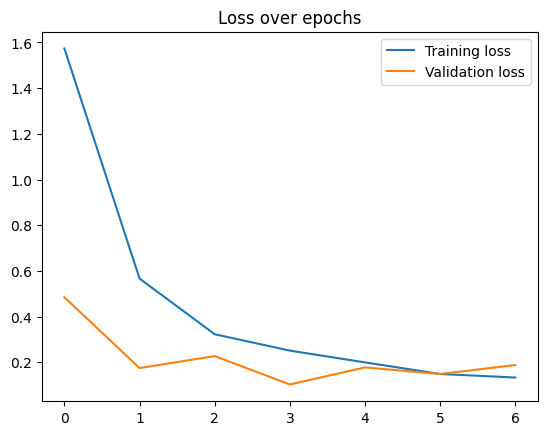

In [ ]:
# Visualize Loss

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## 4: Testing the Model

In [ ]:
# Prediction function
def predict(model, tensor_img, device):
  model.eval()
  with torch.no_grad():
    tensor_img = tensor_img.to(device) # Move to GPU
    output = model(tensor_img)

    # Activation Function Softmax - get a list of probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
  return probabilities.cpu().numpy().flatten()

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

In [ ]:
# Testing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform_config = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_dataset = PlayingCardDataset(data_dir=test_data_dir, transform=transform_config)

# Testing loop
class_names = test_dataset.classes # All classes name

correct_count = 0 # keep track of correct predictions

# For Confusion Matrix & Classification Report
all_labels = []
all_predictions = []

for img, label in test_dataset:

  probabilities = predict(model, img.unsqueeze(0), device)
  highest_prob = np.argmax(probabilities)

  all_predictions.append(highest_prob)
  all_labels.append(label)

  if highest_prob == label:
    correct_count += 1
  # else:
  #   print("INCORRECT")
  #   print(f"- Predict: {highest_prob} - {class_names[highest_prob]}")
  #   print(f"- Actual: {label} - {class_names[label]}")


# Final stat
print(f"Correctly Predicted: {correct_count}/{len(test_dataset)}")
print(f"Accuracy: {round(100 * (correct_count/len(test_dataset)), 2)}%")


Correctly Predicted: 256/265
Accuracy: 96.6%


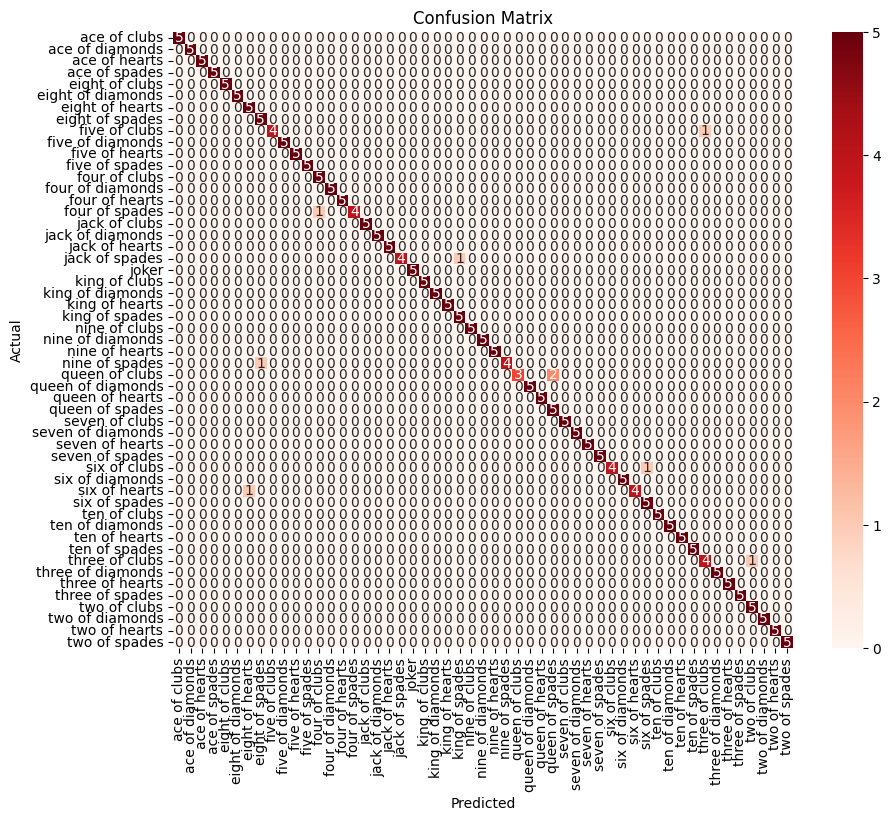

In [119]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report (Precision, Recall, and F1-Score)

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=class_names))

# How to understand the report - Ex. ace of clubs
#
# Precision: Of all instances the model predicted to be ace of clubs, 1.00 = 100% is actually ace of clubs
# Recall: Of all the actual ace of clubs in the dataset, 0.80 = 80% were found and predicted by the model
# F1-score: Harmonic mean of precision and recall. The higher the better
# Support: How many ace of clubs in the dataset. In this case there is 5
#
# NOTE:
# Lower Precision means the model predict something else to be ace of clubs
# Lower Recall means the model landed on ace of clubs but predicted something else

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       1.00      1.00      1.00         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       0.83      1.00      0.91         5
  eight of spades       0.83      1.00      0.91         5
    five of clubs       1.00      0.80      0.89         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       1.00      1.00      1.00         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       0.83      1.00      0.91         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of spades       1.00      0.80      0.89       

## 5: Visualize Predictions

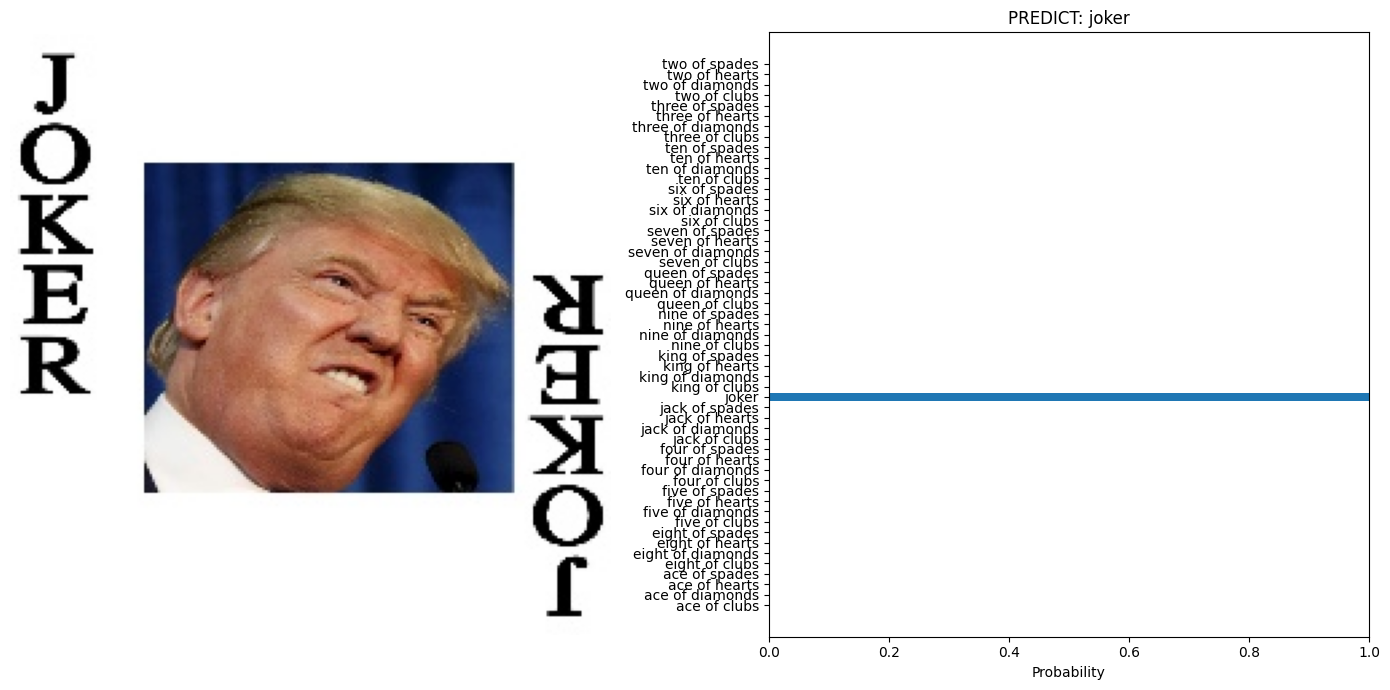

In [ ]:
# Visualize Predictions

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    predicted_class = class_names[np.argmax(probabilities)]
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title(f"PREDICT: {predicted_class}")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = f"{test_data_dir}/joker/4.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

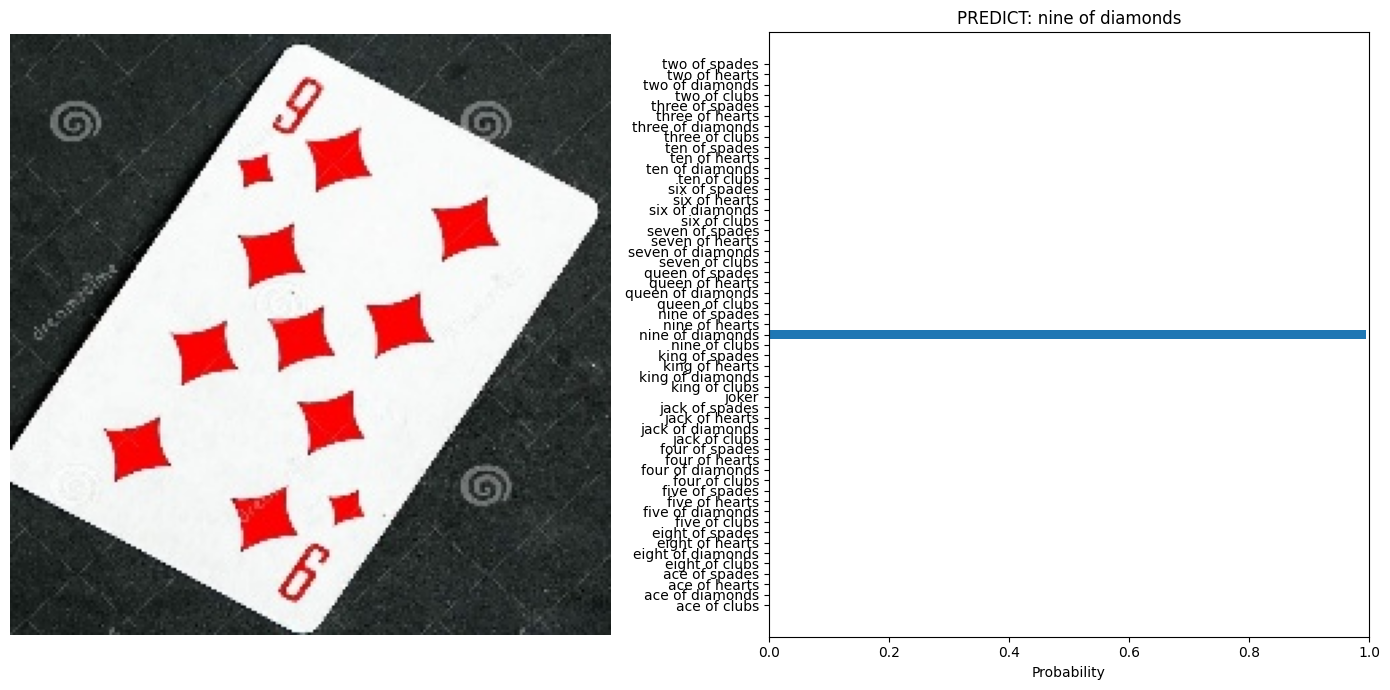

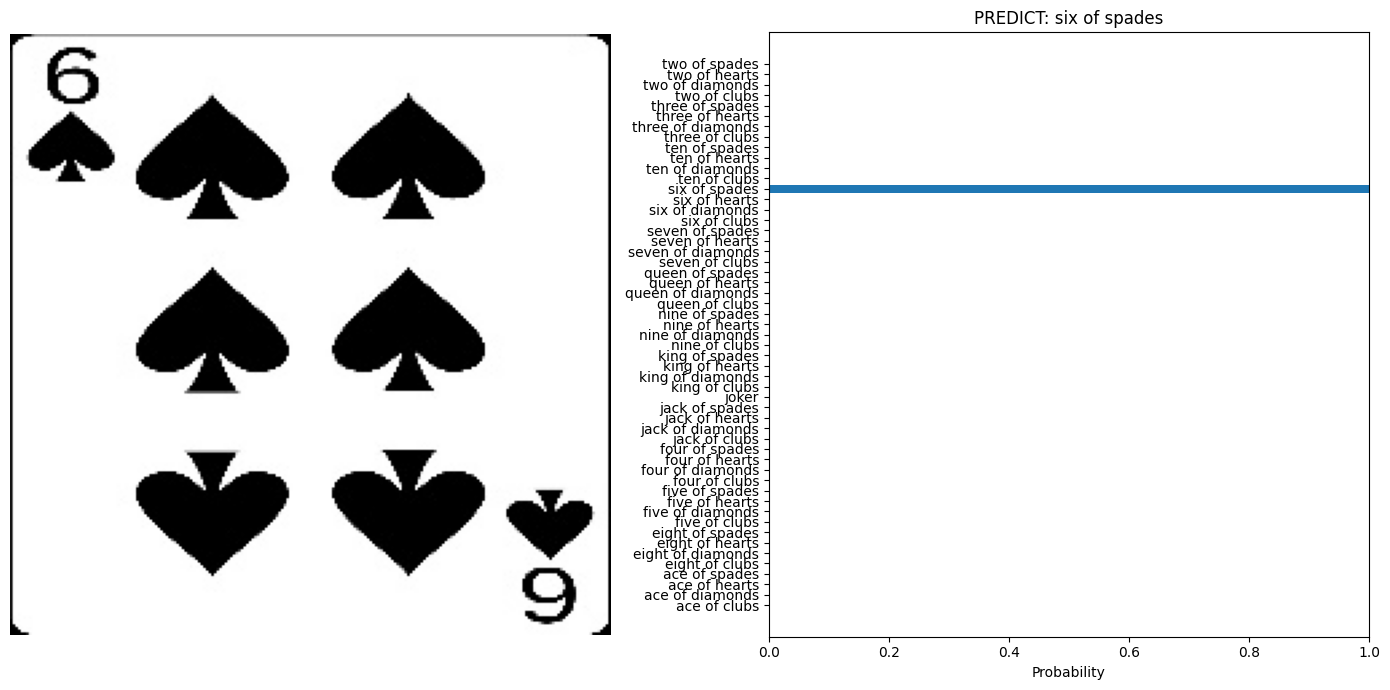

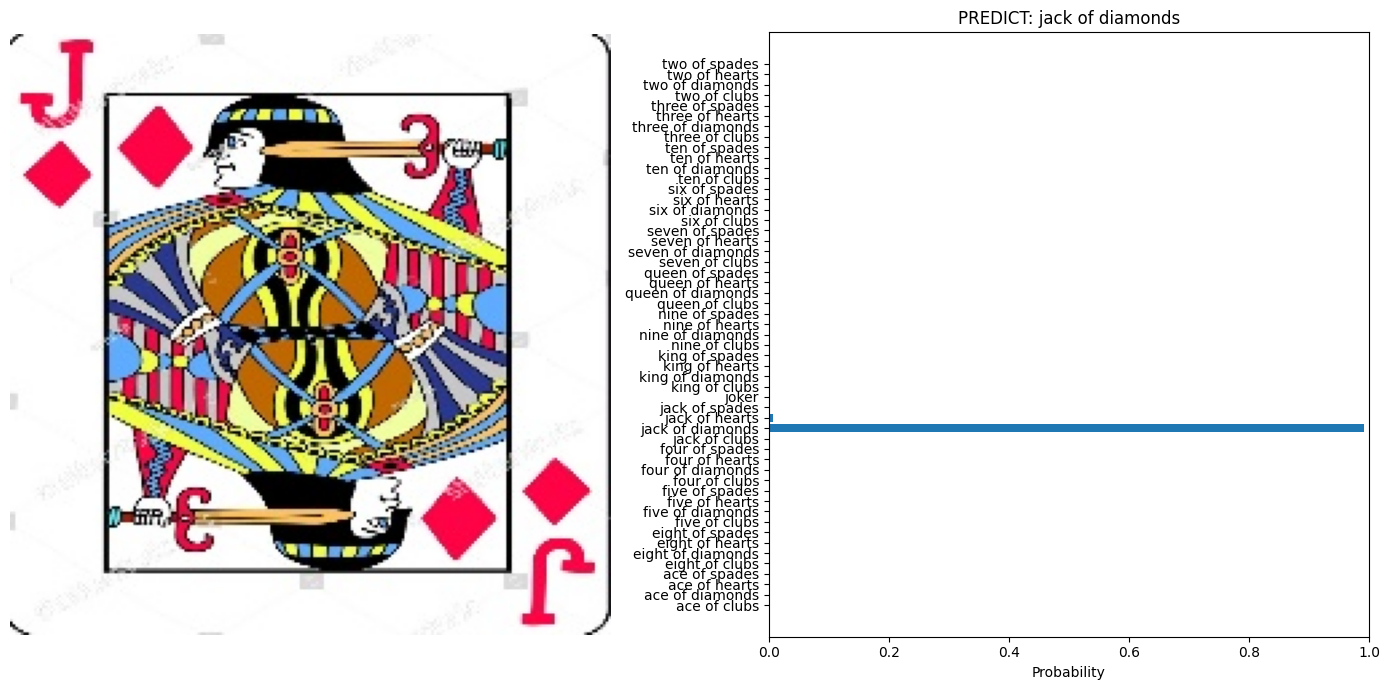

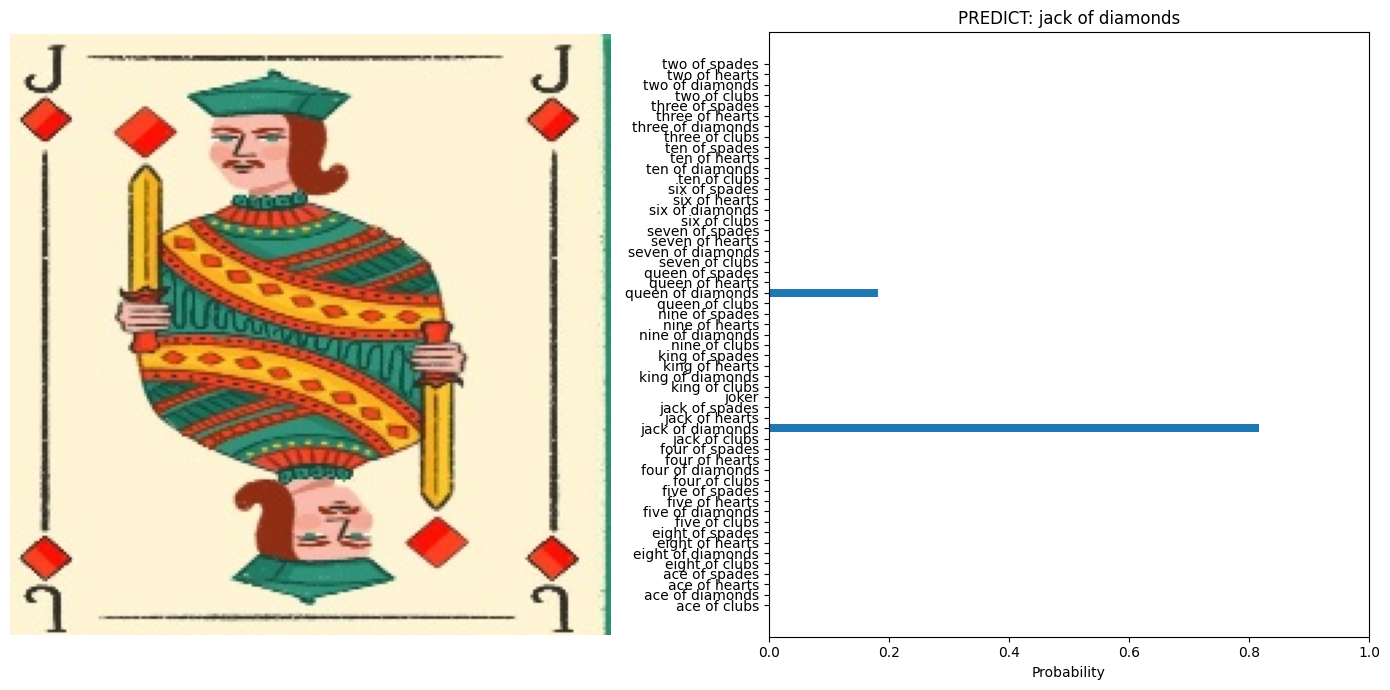

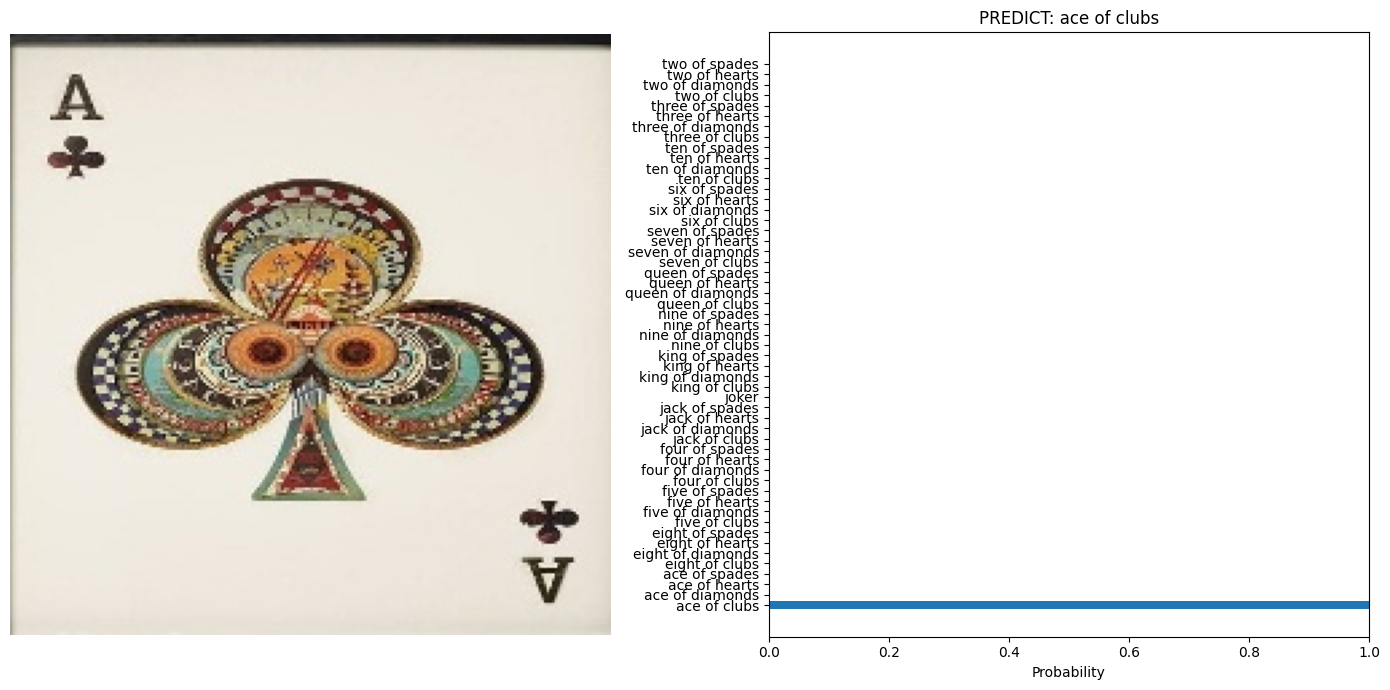

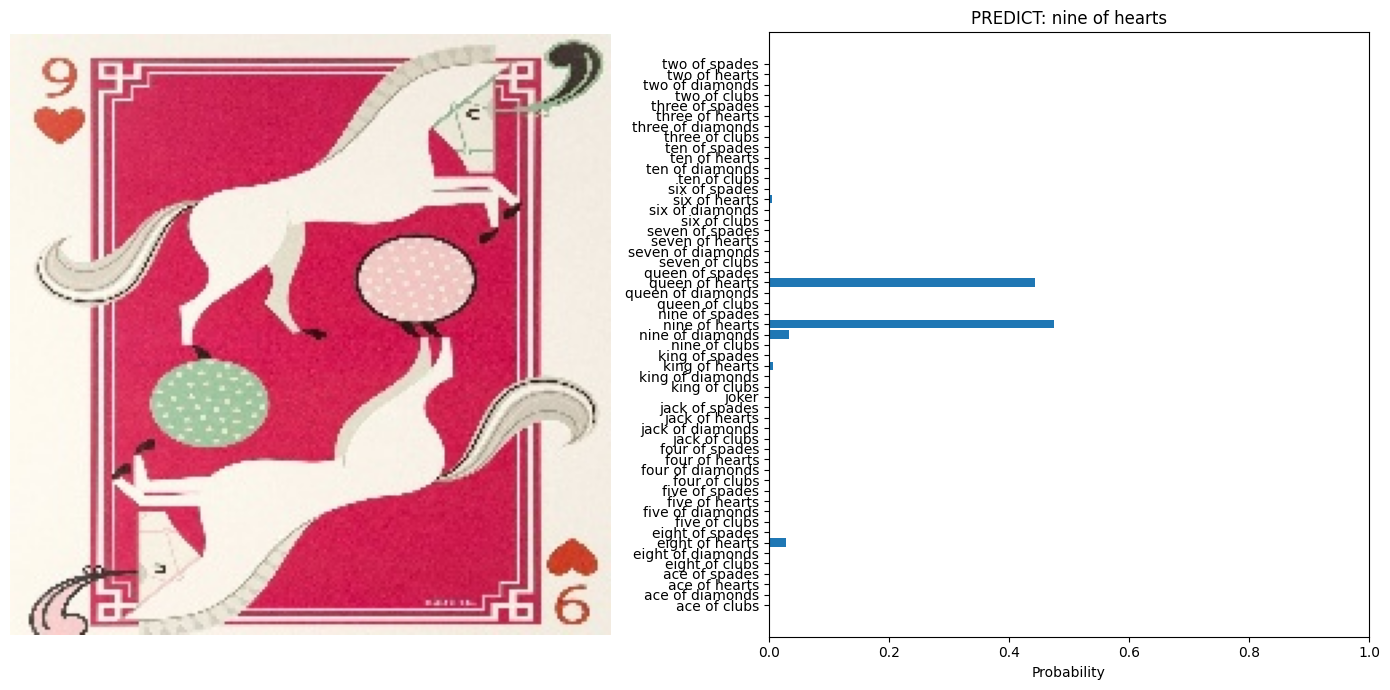

In [ ]:
from glob import glob

how_many_to_visualize = 6

test_images = glob(f'..{test_data_dir}/*/*')
test_examples = np.random.choice(test_images, how_many_to_visualize)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)